In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class TIFDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        # 이미지 파일 이름에서 필요한 부분 추출
        parts = self.images[idx].split('_')
        # 파일 이름 형식에 따라 적절한 임분고 정보 파일 이름 구성
        if len(parts) == 4:
            # 'AP_10_37604057_0020.tif' 형식
            info_name = f"{parts[0]}_{parts[1]}_SH_{parts[2]}_{parts[3]}"
        elif len(parts) == 3:
            # 'SN_10_0535.tif' 형식
            info_name = f"{parts[0]}_{parts[1]}_SH_{parts[2]}"
        else:
            raise ValueError(f"Unexpected file name format: {self.images[idx]}")


        image = tiff.imread(img_name)
        info_path = os.path.join(self.image_dir.replace("IMAGE", "SH"), info_name)  # 임분고 정보 파일 경로
        info = tiff.imread(info_path)  # 임분고 정보 로드
        # 이미지 데이터 타입을 uint8로 변환
        image = image.astype(np.uint8)
        info = info.astype(np.uint8)
        if self.transform:
            image = self.transform(image)
            info = self.transform(info)
        return image, info  # 이미지와 임분고 정보 반환
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

AP10F_IMAGE_dataset = TIFDataset('Dataset\Training\image\AP10_Forest_IMAGE', transform=transform)
AP10C_IMAGE_dataset = TIFDataset('Dataset\Training\image\AP10_City_IMAGE', transform=transform)
AP25F_IMAGE_dataset = TIFDataset('Dataset\Training\image\AP25_Forest_IMAGE', transform=transform)
AP25C_IMAGE_dataset = TIFDataset('Dataset\Training\image\AP25_City_IMAGE', transform=transform)
SN10F_IMAGE_dataset = TIFDataset('Dataset\Training\image\SN10_Forest_IMAGE', transform=transform)


## 임분고 정보가 추가된 tSNE

c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead

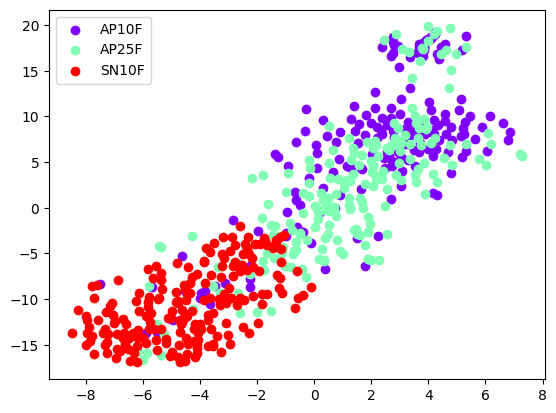

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# 예시: 다섯 개의 데이터셋 로드 및 레이블 생성
datasets = {"AP10F":AP10F_IMAGE_dataset, 
            # "AP10C":AP10C_IMAGE_dataset, 
            "AP25F":AP25F_IMAGE_dataset, 
            # "AP25C":AP25C_IMAGE_dataset, 
            "SN10F":SN10F_IMAGE_dataset}
combined_images = []
combined_labels = []

for name, dataset in datasets.items():
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
    images, infos = next(iter(dataloader))
    # 이미지와 임분고 정보를 채널 차원을 따라 결합
    images = torch.cat((images, infos), dim=1)
    labels = [name] * len(images)  # 데이터셋 이름을 레이블로 사용

    combined_images.append(images)
    combined_labels.extend(labels)  # 리스트 확장

combined_images = torch.cat(combined_images, 0)

# 이미지를 2D 벡터로 변환
images_2d = combined_images.view(combined_images.shape[0], -1).numpy()

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(images_2d)

# 고유한 레이블과 색상 매핑
unique_labels = np.unique(combined_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    idx = [i for i, l in enumerate(combined_labels) if l == label]
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c=[color], label=label)

plt.legend()
plt.show()

## 임분고 정보가 없는 tSNE

c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


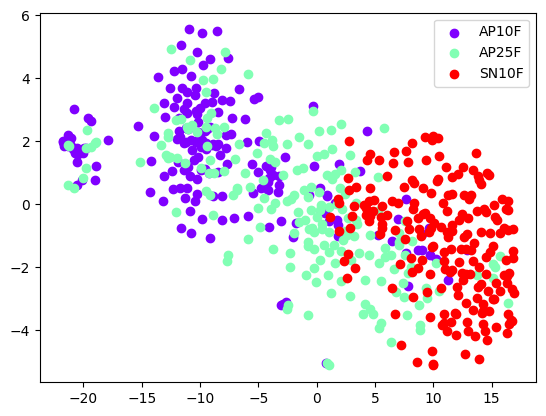

In [3]:
combined_images = []
combined_labels = []

for name, dataset in datasets.items():
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
    images, _ = next(iter(dataloader))
    # 이미지와 임분고 정보를 채널 차원을 따라 결합
    
    labels = [name] * len(images)  # 데이터셋 이름을 레이블로 사용

    combined_images.append(images)
    combined_labels.extend(labels)  # 리스트 확장

combined_images = torch.cat(combined_images, 0)

# 이미지를 2D 벡터로 변환
images_2d = combined_images.view(combined_images.shape[0], -1).numpy()

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(images_2d)

# 고유한 레이블과 색상 매핑
unique_labels = np.unique(combined_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    idx = [i for i, l in enumerate(combined_labels) if l == label]
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c=[color], label=label)

plt.legend()
plt.show()